In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

from timm import create_model

In [3]:
# Cargar Modelo
model_name = "vit_base_patch16_224"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device = ", device)
model = create_model(model_name, pretrained=True).to(device)

device =  cuda


In [4]:
# Transformaciones para test
IMG_SIZE = (224, 224)
NORMALIZE_MEAN = (0.5, 0.5, 0.5)
NORMALIZE_STD = (0.5, 0.5, 0.5)
transforms = [
              T.Resize(IMG_SIZE),
              T.ToTensor(),
              T.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
              ]

transforms = T.Compose(transforms)

In [9]:
%%capture
# ImageNet Data
imagenet_labels = dict(enumerate(open('data/ilsvrc2012_wordnet_lemmas.txt')))

# Imagen de muestra
img = PIL.Image.open('data/santorini.png')
img_tensor = transforms(img).unsqueeze(0).to(device)

In [10]:
patches = model.patch_embed(img_tensor)
print("Tensor: ", img_tensor.shape)
print("Embeddings: ", patches.shape)

Tensor:  torch.Size([1, 3, 224, 224])
Embeddings:  torch.Size([1, 196, 768])


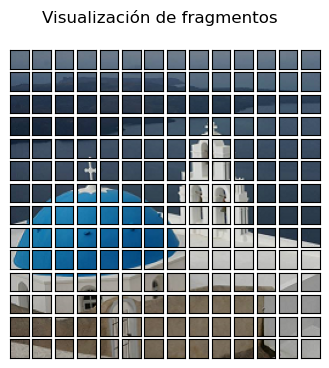

In [14]:
fig = plt.figure(figsize=(4, 4))
fig.suptitle("Visualización de fragmentos")
img = np.asarray(img)
for i in range(0, 196):
    x = i % 14
    y = i // 14
    patch = img[y*16:(y+1)*16, x*16:(x+1)*16]
    ax = fig.add_subplot(14, 14, i+1)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(patch)

In [15]:
pos_embed = model.pos_embed
print(pos_embed.shape)

torch.Size([1, 197, 768])


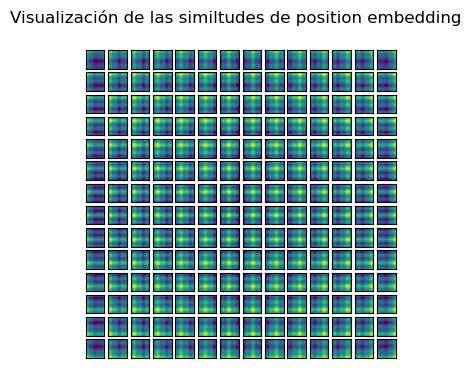

In [17]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
fig = plt.figure(figsize=(4, 4))
fig.suptitle("Visualización de las similtudes de position embedding")
for i in range(1, pos_embed.shape[1]):
    sim = F.cosine_similarity(pos_embed[0, i:i+1], pos_embed[0, 1:], dim=1)
    sim = sim.reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(14, 14, i)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(sim)

In [18]:
transformer_input = torch.cat((model.cls_token, patches), dim=1) + pos_embed
print("Transformer input: ", transformer_input.shape)

Transformer input:  torch.Size([1, 197, 768])


In [19]:
print(f"Tensor de entrada para el Transformer (z0): {transformer_input.shape}")
x = transformer_input.clone()
for i, blk in enumerate(model.blocks):
    print("Encoder {}".format(i))
    x = blk(x)
x = model.norm(x)
transformer_output = x[:, 0]
print(f"Vector de salida Transformer (z12-0): {transformer_output.shape}")

Tensor de entrada para el Transformer (z0): torch.Size([1, 197, 768])
Encoder 0
Encoder 1
Encoder 2
Encoder 3
Encoder 4
Encoder 5
Encoder 6
Encoder 7
Encoder 8
Encoder 9
Encoder 10
Encoder 11
Vector de salida Transformer (z12-0): torch.Size([1, 768])


In [20]:
print("Bloque de atención (Multi-head) del Transformer:")
attention = model.blocks[0].attn
print(attention)
print("Entrada del transformer:", transformer_input.shape)

Bloque de atención (Multi-head) del Transformer:
Attention(
  (qkv): Linear(in_features=768, out_features=2304, bias=True)
  (attn_drop): Dropout(p=0.0, inplace=False)
  (proj): Linear(in_features=768, out_features=768, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
)
Entrada del transformer: torch.Size([1, 197, 768])


In [21]:
# Expandir dimensión
transformer_input_expanded = attention.qkv(transformer_input)[0]
print("Expandir a: ", transformer_input_expanded.shape)

Expandir a:  torch.Size([197, 2304])


In [22]:
# Dividir qkv en varios vectores q, k, y v para multi-head attention
qkv = transformer_input_expanded.reshape(197, 3, 12, 64)  
print("Dividir qkv : ", qkv.shape)
q = qkv[:, 0].permute(1, 0, 2)
k = qkv[:, 1].permute(1, 0, 2)
kT = k.permute(0, 2, 1) 
print("Transpuesta ks: ", kT.shape)

Dividir qkv :  torch.Size([197, 3, 12, 64])
Transpuesta ks:  torch.Size([12, 64, 197])


Attention Matrix:  torch.Size([12, 197, 197])


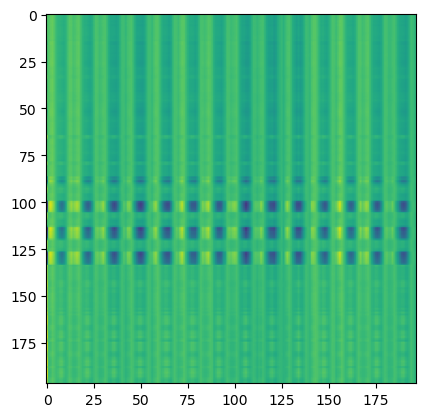

In [23]:
# Matriz de Atención
attention_matrix = q @ kT
print("Attention Matrix: ", attention_matrix.shape)
plt.imshow(attention_matrix[3].detach().cpu().numpy())

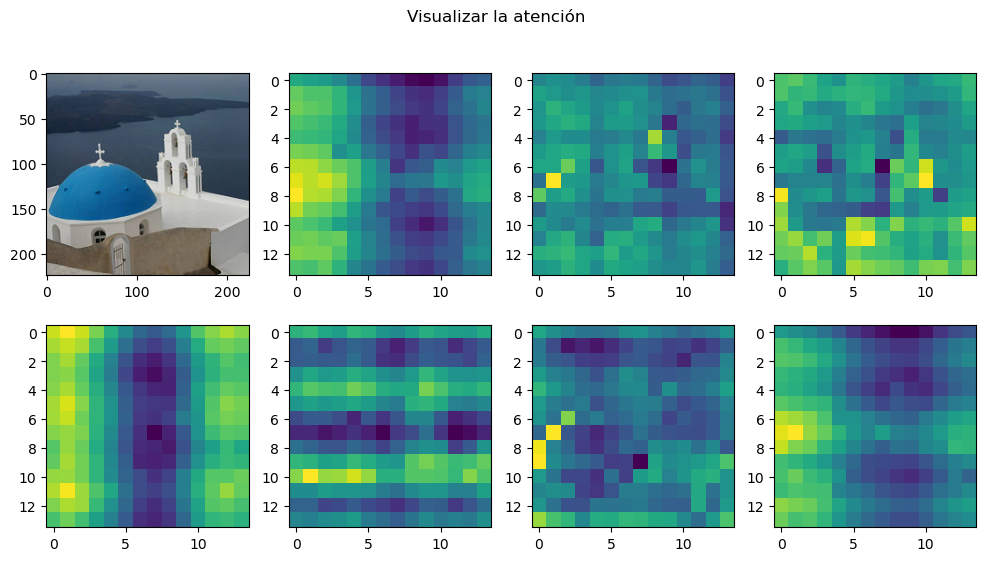

In [26]:
fig = plt.figure(figsize=(12, 6))
fig.suptitle("Visualizar la atención")
img = np.asarray(img)
ax = fig.add_subplot(2, 4, 1)
ax.imshow(img)
for i in range(7):
    attn_heatmap = attention_matrix[i, 100, 1:].reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(2, 4, i+2)
    ax.imshow(attn_heatmap)

Text(0.5, 0, 'class id')

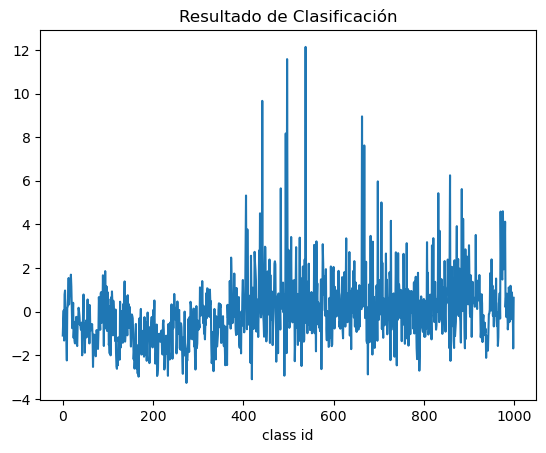

In [28]:
result = model.head(transformer_output)
result_label_id = int(torch.argmax(result))
plt.plot(result.detach().cpu().numpy()[0])
plt.title("Resultado de Clasificación")
plt.xlabel("class id")

In [29]:
print(f"La imagen es: {imagenet_labels[result_label_id]}")

La imagen es: dome

